In [1]:
#Imports

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import string
string.punctuation
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Про датасет
===

Дані **Disaster Tweets Classification** взяті з платформи Kaggle.
Вони містять такі колонки:
* Текст твітера
* Ключове слово твітера
* Локація
* Таргет, який визначає, чи був цей твіт про катастрофу чи ні. 

Потрібно побудувати модель класифікації, використвуючи техніки NLP. Можна також спробувати використати додаткові колонки, але для деяких записів вони порожні.


Не забудьте розділити датасет на train і test, або зробити кросс-валідацію. 

Напишість про обрані вами метрики, та звітуйте результат роботи моделі. 

In [2]:
#Reading our dataset

df = pd.read_csv('train.csv')
df.head(5)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
#Expanding the dispay of the text column

pd.set_option('display.max_colwidth', 150)
df.head(5)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


In [4]:
#Checking for missing values

df.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [5]:
#Deleting rows with missing keywords and dropping the location column

df = df.dropna(axis=0, how='any')
df = df[['keyword', 'text', 'target']]
df = df.reset_index(drop = True)
    
df.isnull().sum()

keyword    0
text       0
target     0
dtype: int64

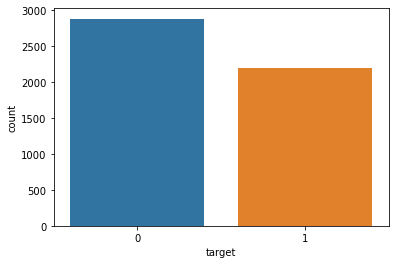

In [6]:
#The dataset seems quite balanced.

sns.countplot(x = df['target'], label='target');

## Text Preprocessing

In [7]:
#Creating function for the text preprocessing 
#(removing punctuation and stop words, distinguishing links and usernames, applying lemmatization)

def text_preprocessing(text):
    custom_punct = string.punctuation.replace('@', '')
    no_punct = [i for i in text if i not in custom_punct]
    no_punct = "".join(no_punct)
    new_text = [] 
    for t in no_punct.split():
        t = 'USER' if t.startswith('@') and len(t) > 1 else t
        t = 'HTTP' if t.startswith('http') else t
        new_text.append(t)
    new_text = " ".join(new_text)
    
    stop_words = stopwords.words('english')
    stop_words.extend(['USER', 'HTTP'])
    no_stop_words = [i for i in new_text.split() if i not in stop_words]
    lowercase = [i.lower() for i in no_stop_words]
    lowercase = [i.lower() for i in no_stop_words]
    wordnet_lemmatizer = WordNetLemmatizer()
    lemma_text = [wordnet_lemmatizer.lemmatize(word) for word in lowercase]
    return ' '.join(lemma_text)

In [8]:
#Let's apply our function to the text data

df['text']= df['text'].apply(lambda x: text_preprocessing(x))
df.head(20)

,keyword,text,target
0,ablaze,wholesale market ablaze,1
1,ablaze,we always try bring heavy metal rt,0
2,ablaze,africanbaze breaking newsnigeria flag set ablaze aba,1
3,ablaze,cry set ablaze,0
4,ablaze,on plus side look at the sky last night it was ablaze,0
5,ablaze,mufc theyve built much hype around new acquisition i doubt set epl ablaze season,0
6,ablaze,inec office abia set ablaze,1
7,ablaze,ablaze lord d,0
8,ablaze,check nsfw,0
9,ablaze,had awesome time visiting cfc head office ancop site ablaze thanks tita vida taking care us,0


In [9]:
#Merging 'text' and 'keyword' columns

df['text_keywords'] = df['text'] + ' ' + df['keyword']
df = df.drop(columns = ['keyword','text'])
df

,target,text_keywords
0,1,wholesale market ablaze ablaze
1,0,we always try bring heavy metal rt ablaze
2,1,africanbaze breaking newsnigeria flag set ablaze aba ablaze
3,0,cry set ablaze ablaze
4,0,on plus side look at the sky last night it was ablaze ablaze
...,...,...
5075,0,on bright side i wrecked wrecked
5076,0,he gone you relax i thought wife wrecked cake goner mind lol whoop wrecked
5077,0,three day work theyve pretty much wrecked hahaha shoutout family one wrecked
5078,0,fx forex trading cramer igers 3 word wrecked disney stock wrecked


## Modeling

In [10]:
#Train-test split and CountVectorizer application

X = df['text_keywords']
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state= 20)

count_vect = CountVectorizer()

X_train_counts = count_vect.fit_transform(X_train)
X_test_counts = count_vect.transform(X_test)

X_train_counts.shape, X_test_counts.shape

((3556, 9072), (1524, 9072))

>### Now let's make a classification with the help of Logistic Regression, multinomial Naive Bayes classifier, and Random Forest Classifier. 
>### We are going to evaluate them with the help of a classification report which contains precision, recall, f1-score, and accuracy.
>### Also, let's build a confusion matrix for each model.

In [11]:
def class_models(model, Xtrain, Xtest, ytrain, ytest):
    
    model.fit(Xtrain, ytrain)
    ypred = model.predict(Xtest)
    cm = confusion_matrix(ytest, ypred, labels = model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    fig, ax = plt.subplots(figsize=(8,8))
    disp.plot(ax=ax);
    
    print(classification_report(ytest, ypred))

              precision    recall  f1-score   support

           0       0.79      0.84      0.82       865
           1       0.77      0.71      0.74       659

    accuracy                           0.79      1524
   macro avg       0.78      0.78      0.78      1524
weighted avg       0.79      0.79      0.79      1524



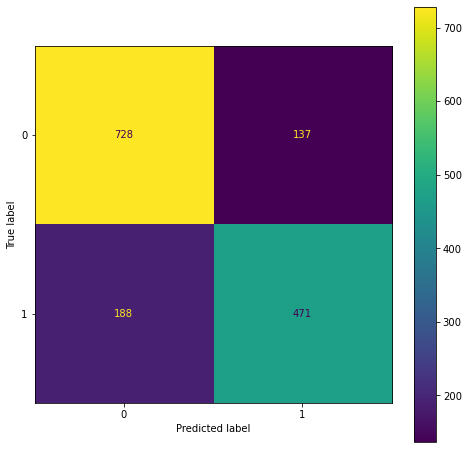

In [12]:
#Logistic Regression

lr = LogisticRegression()

class_models(lr, X_train_counts, X_test_counts, y_train, y_test)

              precision    recall  f1-score   support

           0       0.81      0.84      0.82       865
           1       0.78      0.75      0.76       659

    accuracy                           0.80      1524
   macro avg       0.80      0.79      0.79      1524
weighted avg       0.80      0.80      0.80      1524



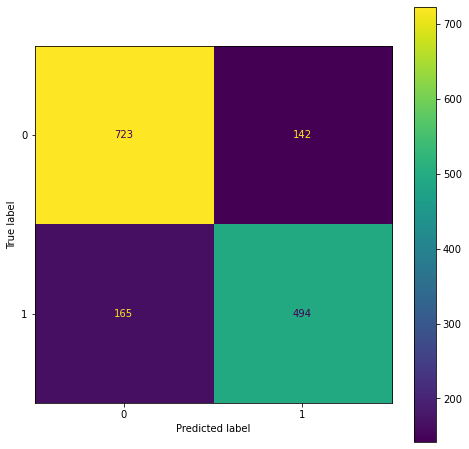

In [13]:
#Multinomial Naive Bayes classifier

nb = MultinomialNB()
class_models(nb, X_train_counts, X_test_counts, y_train, y_test)

              precision    recall  f1-score   support

           0       0.76      0.88      0.81       865
           1       0.80      0.63      0.71       659

    accuracy                           0.77      1524
   macro avg       0.78      0.76      0.76      1524
weighted avg       0.78      0.77      0.77      1524



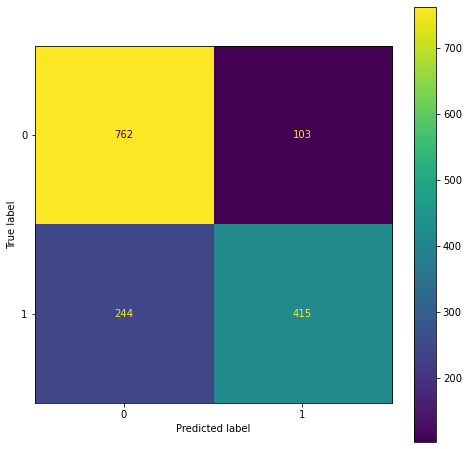

In [14]:
#Random Forest Classifier

rf = RandomForestClassifier()
class_models(rf, X_train_counts, X_test_counts, y_train, y_test)

> ### Conclusion: Multinomial Naive Bayes classifier helped us to reach the accuracy of 0.8. Although it is meant for multiclass classification tasks, it also worked very well for this binary classification.